In [1]:
pip install qutip==4.7.6

Note: you may need to restart the kernel to use updated packages.


In [2]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

%matplotlib ipympl

In [3]:
font = {
        'weight' : 'bold',
        'size'   : 16}
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', **font)

In [4]:
# Physical parameters
omega = 1 # Energy hopping
g_0 = 0
npart = int(60)
tau = int(120) # total time evolution
delta = 1

alpha_gvars = (64 * abs(delta)**2 * (np.sin(np.pi/npart))**2)**(-1)
beta_gvars = -2 * omega * np.cos(np.pi/npart)
gamma_gvars = 2 * abs(delta) * np.sin(np.pi/npart)
gvars = {'alpha': alpha_gvars, 'beta': beta_gvars, 'gamma': gamma_gvars, 'tau': tau}

g_f = -3*omega

gvars_lin = {'gf': g_f, 'tau': tau}

temperature = 0.1 # Changes p_0
t_0 = 0
t_f = tau

# Formatting parameters
amt_times = 200 # How many points we calculate

ts = np.linspace(t_0, t_f, amt_times)

In [5]:
def g_t(t: float, gvars: dict):
  # Minimal action solution
  return gvars['beta'] + gvars['gamma'] * np.tan((1-t/gvars['tau']) * np.arctan((g_0 - gvars['beta'])/gvars['gamma'])
                                                 + t/gvars['tau'] * np.arctan((g_f - gvars['beta'])/gvars['gamma']) )

In [6]:
def g_lin_t(t: float, gvars: dict):
    # Linear ramp solution
    return g_0 + (gvars['gf'] - g_0) * t / gvars['tau']

In [7]:
def H_k_func(k):
  array = np.array([[0,np.conjugate(2j * delta * np.sin(k))],[2j * delta * np.sin(k),0]])
  Hstatic = -2 * omega * np.cos(k) * qutip.sigmaz() - qutip.Qobj(array)
  Hdinamic = -qutip.sigmaz()
  H_k = [Hstatic, [Hdinamic, g_t]]
  return H_k

def H_k_lin_func(k):
  array = np.array([[0,np.conjugate(2j * delta * np.sin(k))],[2j * delta * np.sin(k),0]])
  Hstatic = -2 * omega * np.cos(k) * qutip.sigmaz() - qutip.Qobj(array)
  Hdinamic = -qutip.sigmaz()
  H_k = [Hstatic, [Hdinamic, g_lin_t]]
  return H_k

def H_k_t(t:float, k:float, gvars: dict):
  array = np.array([[0,np.conjugate(1j * delta * np.sin(k))],[1j * delta * np.sin(k),0]])
  Hstatic = -2 * omega * np.cos(k) * qutip.sigmaz() - 2 * qutip.Qobj(array)
  Hdinamic = -qutip.sigmaz()
  return Hstatic + Hdinamic * g_t(t, gvars)

def H_k_lin_t(t:float, k:float, gvars: dict):
  array = np.array([[0,np.conjugate(2j * delta * np.sin(k))],[2j * delta * np.sin(k),0]])
  Hstatic = -2 * omega * np.cos(k) * qutip.sigmaz() - qutip.Qobj(array)
  Hdinamic = -qutip.sigmaz()
  return Hstatic + Hdinamic * g_lin_t(t, gvars)

In [8]:
def Ho_k_func(k):
    H_odd_static = -2 * omega * np.cos(k) * qutip.identity(2)
    H_odd_dynamic = -qutip.identity(2)
    return [H_odd_static, [H_odd_dynamic, g_t]]

In [9]:
def H_lino_k_func(k):
    H_odd_static = -2 * omega * np.cos(k) * qutip.identity(2)
    H_odd_dynamic = -qutip.identity(2)
    return [H_odd_static, [H_odd_dynamic, g_lin_t]]

In [10]:
def f_k_dag(k, N):
    matrix = 1/(2*np.sqrt(N))*np.array([[0,0, np.exp(-1j*k)+np.exp(-1j*k*N),-np.exp(1j*k)-np.exp(1j*k*N)],
                                                     [0,0, np.exp(-1j*k)-np.exp(-1j*k*N),np.exp(1j*k)-np.exp(1j*k*N)],
                                                     [np.exp(1j*k)-np.exp(1j*k*N), np.exp(1j*k)+np.exp(1j*k*N), 0, 0],
                                                     [-np.exp(-1j*k)+np.exp(-1j*k*N), np.exp(-1j*k)+np.exp(-1j*k*N), 0,0]])
    return qutip.Qobj(matrix, dims=[[2,2],[2,2]])

In [11]:
def beta_k(k, gfinal):
    deltatilde= -2j * delta * np.sin(k)
    epsk = -2*omega* np.cos(k) - gfinal
    ebulk = np.sqrt(epsk**2 + np.abs(deltatilde)**2)
    uk = -1j * np.sqrt((ebulk+epsk)/(ebulk))
    vk = ((ebulk-epsk)/(deltatilde)) * uk
    matrix = np.array([[0, 0, 0, -vk],
                        [0, 0, 0, uk],
                         [uk, vk, 0, 0],
                         [0, 0, 0, 0]])
    return qutip.Qobj(matrix, dims=[[2,2],[2,2]])

## Fidelity vs. $\tau$

In [12]:
tmin = 0.5
tmax = 120
amt_times = 200 # How many points we calculate
fidel_interval = np.linspace(tmin,tmax,amt_times)

In [13]:
fidele = []
fidelo = []
fidel_line = []
fidel_lino = []

for i in fidel_interval:
    fidelvale = 1
    fidelval_line = 1
    fidelvalo = 1
    fidelval_lino = 1
    
    for l in range(1, int(npart/2)+1):
        k = (2*l-1)*np.pi/npart
        tlistaux = np.linspace(t_0,i,10)

        gvarsaux = {'alpha': alpha_gvars, 'beta': beta_gvars, 'gamma': gamma_gvars, 'tau': i}
        gvars_linaux = {'gf': g_f, 'tau': i}

        H_k = H_k_func(k)
        Ho_k = Ho_k_func(k)
        H_k_lin = H_k_lin_func(k)
        H_lino_k = H_lino_k_func(k)

        options = qutip.solver.Options(nsteps = 100000000, order=5)
        
        if l == 1:
            
            gse_0aux = H_k_t(t_0,k,gvarsaux).eigenstates()[1][0]
            gse_0 = qutip.tensor(qutip.Qobj(np.array([1,0])), gse_0aux)
            gs_taux = H_k_t(i,k,gvarsaux).eigenstates()[1][0]
            gs_t = qutip.tensor(qutip.Qobj(np.array([1,0])), gs_taux)

            
            operator_f_dag = f_k_dag(k, npart)
            gso_0 = (operator_f_dag * gse_0)
        
            operator_beta = beta_k(k, g_f)
            es_t = (operator_beta.dag() * gs_t)
            
            
            gs_line_0aux = H_k_lin_t(0,k,gvars_linaux).eigenstates()[1][0]
            gs_line_0 = qutip.tensor(qutip.Qobj(np.array([1,0])), gs_line_0aux)            
            gs_lin_taux = H_k_lin_t(i,k,gvars_linaux).eigenstates()[1][0]
            gs_lin_t = qutip.tensor(qutip.Qobj(np.array([1,0])), gs_lin_taux)
            
            gs_lino_0 = (operator_f_dag * gs_line_0)
            es_lin_t = (operator_beta.dag() * gs_lin_t)
            
            H_k_even_ext = [qutip.tensor(qutip.Qobj(np.array([[1,0],[0,0]])), H_k[0]),[qutip.tensor(qutip.Qobj(np.array([[1,0],[0,0]])), H_k[1][0]),H_k[1][1]]]
            H_k_odd_ext = [qutip.tensor(qutip.Qobj(np.array([[0,0],[0,1]])), Ho_k[0]),[qutip.tensor(qutip.Qobj(np.array([[0,0],[0,1]])), Ho_k[1][0]),Ho_k[1][1]]] 
            H_staticaux = (H_k_even_ext[0] + H_k_odd_ext[0])
            H_dynaux = (H_k_even_ext[1][0] + H_k_odd_ext[1][0])
            H_k_ext = [H_staticaux,[H_dynaux,g_t]]
             
            H_k_lin_even_ext = [qutip.tensor(qutip.Qobj(np.array([[1,0],[0,0]])), H_k_lin[0]),[qutip.tensor(qutip.Qobj(np.array([[1,0],[0,0]])), H_k_lin[1][0]),H_k_lin[1][1]]]
            H_k_lin_odd_ext = [qutip.tensor(qutip.Qobj(np.array([[0,0],[0,1]])), H_lino_k[0]),[qutip.tensor(qutip.Qobj(np.array([[0,0],[0,1]])), H_lino_k[1][0]),H_lino_k[1][1]]] 
            H_lin_staticaux = (H_k_lin_even_ext[0] + H_k_lin_odd_ext[0])
            H_lin_dynaux = (H_k_lin_even_ext[1][0] + H_k_lin_odd_ext[1][0])
            H_k_lin_ext = [H_lin_staticaux,[H_lin_dynaux, g_lin_t]]            


            evole = qutip.mesolve(H_k_ext, gse_0, tlistaux, [], [], args = gvarsaux, options = options).states
            evolo = qutip.mesolve(H_k_ext, gso_0, tlistaux, [], [], args = gvarsaux, options = options).states

            evol_line = qutip.mesolve(H_k_lin_ext, gs_line_0, tlistaux, [], [], args = gvars_linaux).states
            evol_lino = qutip.mesolve(H_k_lin_ext, gs_lino_0, tlistaux, [], [], args = gvars_linaux).states

            
            fidelvale *= np.linalg.norm(np.linalg.multi_dot([gs_t.dag(), evole[-1]]))
            fidelval_line *= np.linalg.norm(np.linalg.multi_dot([gs_lin_t.dag(), evol_line[-1]]))
            fidelvalo *= np.linalg.norm(np.linalg.multi_dot([es_t.dag(), evolo[-1]]))
            fidelval_lino *= np.linalg.norm(np.linalg.multi_dot([es_lin_t.dag(), evol_lino[-1]]))
        
        else:
        
            gs_0 = H_k_t(t_0,k,gvarsaux).eigenstates()[1][0]
            gs_t = H_k_t(i,k,gvarsaux).eigenstates()[1][0]
            
            evol = qutip.mesolve(H_k, gs_0, tlistaux, [], [], args = gvarsaux, options = options).states
            
            gs_lin_0 = H_k_lin_t(0,k,gvars_linaux).eigenstates()[1][0]
            gs_lin_t = H_k_lin_t(i,k,gvars_linaux).eigenstates()[1][0]
            evol_lin = qutip.mesolve(H_k_lin, gs_lin_0, tlistaux, [], [], args = gvars_linaux).states

            valaux = np.linalg.norm(np.linalg.multi_dot([gs_t.dag(), evol[-1]]))
            vallinaux = np.linalg.norm(np.linalg.multi_dot([gs_lin_t.dag(), evol_lin[-1]]))
            
            fidelvale *= valaux
            fidelvalo *= valaux
            fidelval_line *= vallinaux
            fidelval_lino *= vallinaux
  
    fidelvale = fidelvale**2
    fidelvalo = fidelvalo**2
    fidelval_line = fidelval_line**2
    fidelval_lino = fidelval_lino**2
    
    fidele += [fidelvale]
    fidelo += [fidelvalo]
    fidel_line += [fidelval_line]
    fidel_lino += [fidelval_lino]

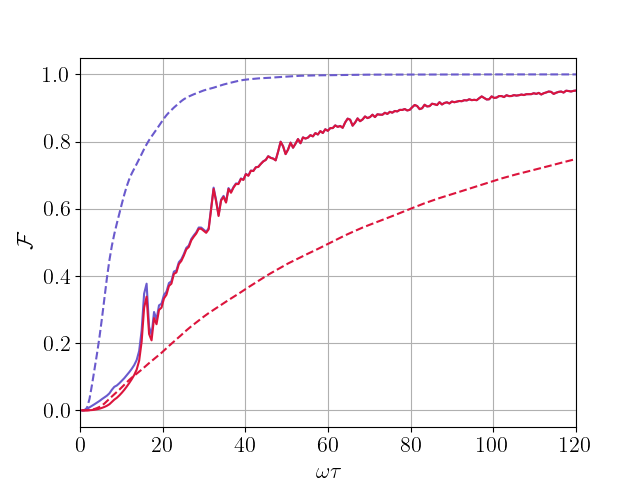

In [133]:
# Plot the results
fig, ax = plt.subplots()

# Plot the results for linear ramp and action ramp
ax.plot(fidel_interval, np.array(fidelo), color='slateblue', label='MA odd')
ax.plot(fidel_interval, np.array(fidel_lino), color='slateblue', linestyle='--', label='LR odd')
ax.plot(fidel_interval, np.array(fidele), color='crimson', label='MA even')
ax.plot(fidel_interval, np.array(fidel_line), color='crimson', linestyle='--', label='LR even')

# Add vertical lines at specific points
#ax.axvline(x=1 / (4 * np.sin(np.pi / npart)), color='gray', linestyle='dotted', linewidth=2, alpha=0.8)
#ax.axvline(x=npart / 4, color='black', linestyle='dotted', linewidth=2, alpha=0.8)

# Add labels and grid
ax.set_xlabel(r'$\omega \tau$')
ax.set_ylabel(r'$\mathcal{F}$')
#ax.legend()
ax.grid()

# Show the plot

# plt.ylim(0,1.0)
plt.xlim(0, tmax)
# plt.xlim(0,20)

plt.show()

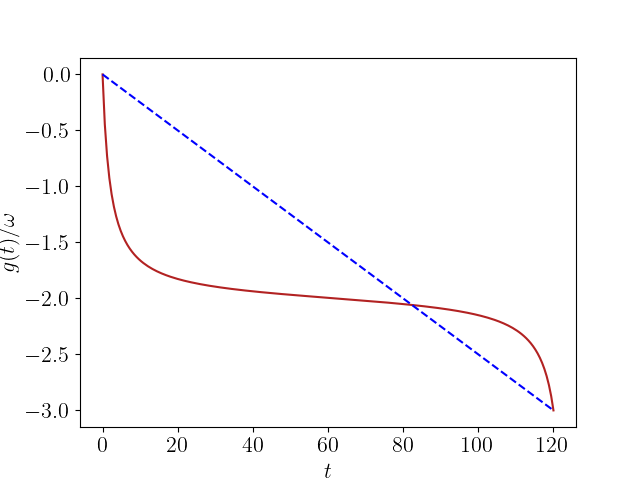

In [15]:
g_values = [g_t(i, gvars)/omega for i in ts]
g_lin_values = [g_lin_t(i, gvars_lin)/omega for i in ts]

fig7,ax7=plt.subplots()

# Axes label
ax7.set_xlabel('$t$')
ax7.set_ylabel('$g(t)/ \\omega$')
ax7.plot(ts, g_values, color='firebrick')
ax7.plot(ts,g_lin_values, color='blue', linestyle='dashed')

title7 = "Normalized $ g(t) $, $ N={} $, ".format(int(npart)) + "$ \\tau={} $".format(int(tau))
#ax7.set_title(title7)